# Lab Multilabel Logistic Regression

![credit_rating](../../../images/credit_rating.jpg)
![credit_rating](https://github.com/YonatanRA/da-ce-case-study/blob/master/images/credit_rating.jpg)


This is the last project at the telecom company. The management thinks that there is a delinquency problem with the customers and wants a credit rating predictive model. A credit rating is a measurement of a person or business entity's ability to repay a financial obligation based on income and past repayment histories. Usually expressed as a credit score, banks and lenders use a credit rating as one of the factors to determine whether to lend money.

Our task is build a multilabel classifier in order to predict the credit rating of our customers.

## 1 - Imports

Import every single library you need here.

In [1]:
# your libraries here

import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np
import pylab as plt 
import seaborn as sns

from sqlalchemy import create_engine


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier as RFC

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split as tts

from sklearn.metrics import f1_score as f1
from sklearn.metrics import confusion_matrix as cm      

from imblearn.over_sampling import SMOTE


## 2 - Load Data

First, we need to load the customers data.

In [2]:
# your code here

DB_LANG='mysql'

DRIVER='pymysql'

USER='root'

PASSWORD='password'

HOST='localhost'

PORT='3306'

SCHEMA='telcom'

In [3]:
connection_string=f'{DB_LANG}+{DRIVER}://{USER}:{PASSWORD}@{HOST}:{PORT}/{SCHEMA}'
        
engine=create_engine(connection_string)

In [4]:
df=pd.read_sql('select * from temporary_table', engine)

df.head()

,id,CustomerID,Churn,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,DroppedCalls,BlockedCalls,UnansweredCalls,CustomerCareCalls,ThreewayCalls,ReceivedCalls,OutboundCalls,InboundCalls,PeakCallsInOut,OffPeakCallsInOut,DroppedBlockedCalls,CallForwardingCalls,CallWaitingCalls,MonthsInService,UniqueSubs,ActiveSubs,ServiceArea,Handsets,HandsetModels,CurrentEquipmentDays,AgeHH1,AgeHH2,ChildrenInHH,HandsetRefurbished,HandsetWebCapable,TruckOwner,RVOwner,Homeownership,BuysViaMailOrder,RespondsToMailOffers,OptOutMailings,NonUSTravel,OwnsComputer,HasCreditCard,RetentionCalls,RetentionOffersAccepted,NewCellphoneUser,NotNewCellphoneUser,ReferralsMadeBySubscriber,IncomeGroup,OwnsMotorcycle,AdjustmentsToCreditRating,HandsetPrice,MadeCallToRetentionTeam,CreditRating,PrizmCode,Occupation,MaritalStatus,Gender,SeniorCitizen,Partner,Dependents,Tenure,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,TenureLevel
0,0,3000002,Yes,24.0,219.0,22.0,0.25,0.0,0.0,-157.0,-19.0,0.7,0.7,6.3,0.0,0.0,97.2,0.0,0.0,58.0,24.0,1.3,0.0,0.3,61,2,1,SEAPOR503,2.0,2.0,361.0,62.0,0.0,No,No,Yes,No,No,Known,Yes,Yes,No,No,Yes,Yes,1,0,No,No,0,4,No,0,30,Yes,1-Highest,Suburban,Professional,No,Female,0,No,No,65,DSL,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),Very Loyal
1,1,3000010,Yes,16.99,10.0,17.0,0.0,0.0,0.0,-4.0,0.0,0.3,0.0,2.7,0.0,0.0,0.0,0.0,0.0,5.0,1.0,0.3,0.0,0.0,58,1,1,PITHOM412,2.0,1.0,1504.0,40.0,42.0,Yes,No,No,No,No,Known,Yes,Yes,No,No,Yes,Yes,0,0,Yes,No,0,5,No,0,30,No,4-Medium,Suburban,Professional,Yes,Male,0,No,Yes,53,DSL,Yes,Yes,No,Yes,No,No,One year,No,Credit card (automatic),Loyal
2,2,3000014,No,38.0,8.0,38.0,0.0,0.0,0.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,0.3,0.0,1.3,3.7,0.0,0.0,0.0,60,1,1,MILMIL414,1.0,1.0,1812.0,26.0,26.0,Yes,No,No,No,No,Unknown,No,No,No,No,No,Yes,0,0,Yes,No,0,6,No,0,Unknown,No,3-Good,Town,Crafts,Yes,Female,0,No,No,1,DSL,No,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,New
3,3,3000022,No,82.28,1312.0,75.0,1.24,0.0,0.0,157.0,8.1,52.0,7.7,76.0,4.3,1.3,200.3,370.3,147.0,555.7,303.7,59.7,0.0,22.7,59,2,2,PITHOM412,9.0,4.0,458.0,30.0,0.0,No,No,Yes,No,No,Known,Yes,Yes,No,No,No,Yes,0,0,Yes,No,0,6,No,0,10,No,4-Medium,Other,Other,No,Female,0,Yes,Yes,35,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),Regular
4,4,3000026,Yes,17.14,0.0,17.0,0.0,0.0,0.0,0.0,-0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53,2,2,OKCTUL918,4.0,3.0,852.0,46.0,54.0,No,No,No,No,No,Known,Yes,Yes,No,No,Yes,Yes,0,0,No,Yes,0,9,No,1,10,No,1-Highest,Other,Professional,Yes,Female,0,No,No,32,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Bank transfer (automatic),Loyal


## 3 - Check target variable

Now we've already the data. We need to check what is the target variable. How many labels we have?. Are the classes balanced?

In [5]:
# your code here

df.CreditRating.value_counts()

2-High       18692
1-Highest     8368
3-Good        8221
5-Low         6320
4-Medium      5227
7-Lowest      2049
6-VeryLow      875
Name: CreditRating, dtype: int64

In [6]:
df.CreditRating.value_counts()/len(df)

2-High       0.375703
1-Highest    0.168194
3-Good       0.165240
5-Low        0.127030
4-Medium     0.105061
7-Lowest     0.041184
6-VeryLow    0.017587
Name: CreditRating, dtype: float64

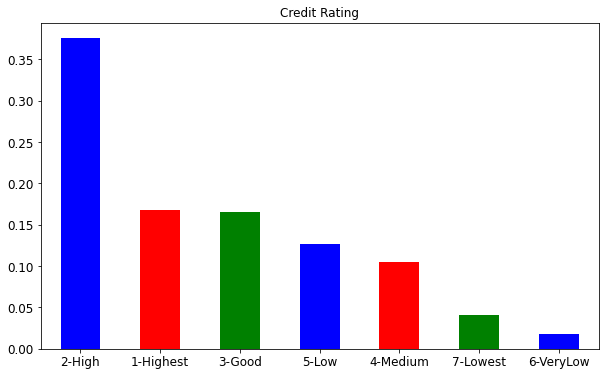

In [7]:
(df.CreditRating.value_counts()/len(df)).plot.bar(color=['b', 'r', 'g'],    # plot customer churn rate
                                                   figsize=(10, 6),
                                                   title='Credit Rating',
                                                   rot=0,
                                                   fontsize=12);

## 4 - Data Transformation

Remember, we need transform our data in order to build a prediction model. Feel free to make every single transformation you want.

In [8]:
# your code here

def change_all_dtypes(df):   
    for c in df.columns:
        try:
            df[c]=df[c].astype(float)
        except:
            continue
            
    return df

In [9]:
df=change_all_dtypes(df)   # change dtypes

In [10]:
# dropping columns

data=df.drop(columns=['CustomerID',
                      'MonthlyMinutes',
                      'HandsetModels',
                      'id',
                      'Handsets',
                      'ReceivedCalls',
                      'MonthsInService',
                      'ServiceArea'
                     ])

In [11]:
data_num=pd.DataFrame(StandardScaler().fit_transform(data._get_numeric_data()),  # standardize numeric columns
                      columns=data._get_numeric_data().columns)

data_obj=data.select_dtypes(include='object')  # get categoric columns


data=pd.concat([data_num, data_obj], axis=1)   # concatenate both dataframes

In [12]:
# label encoding 

le=LabelEncoder()

for c in data.columns:
    if data.dtypes[c]==object:
        le.fit(data[c].astype(str))
        data[c]=le.transform(data[c].astype(str))

In [13]:
data.shape

(49752, 67)

In [14]:
data.head()

,MonthlyRevenue,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,DroppedCalls,BlockedCalls,UnansweredCalls,CustomerCareCalls,ThreewayCalls,OutboundCalls,InboundCalls,PeakCallsInOut,OffPeakCallsInOut,DroppedBlockedCalls,CallForwardingCalls,CallWaitingCalls,UniqueSubs,ActiveSubs,CurrentEquipmentDays,AgeHH1,AgeHH2,RetentionCalls,RetentionOffersAccepted,ReferralsMadeBySubscriber,IncomeGroup,AdjustmentsToCreditRating,SeniorCitizen,Tenure,Churn,ChildrenInHH,HandsetRefurbished,HandsetWebCapable,TruckOwner,RVOwner,Homeownership,BuysViaMailOrder,RespondsToMailOffers,OptOutMailings,NonUSTravel,OwnsComputer,HasCreditCard,NewCellphoneUser,NotNewCellphoneUser,OwnsMotorcycle,HandsetPrice,MadeCallToRetentionTeam,CreditRating,PrizmCode,Occupation,MaritalStatus,Gender,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,TenureLevel
0,-0.783391,-1.045275,-0.288506,-0.413714,-0.124522,-0.568070,-0.452482,-0.587674,-0.311711,-0.565902,-0.366649,-0.254828,-0.723803,-0.492182,-0.310234,-0.471357,-0.572545,-0.020214,-0.274974,0.384227,-0.525372,-0.075394,1.387951,-0.883862,4.775674,-0.128321,-0.193162,-0.129459,-0.140293,-0.438968,1.327621,1,0,0,1,0,0,0,1,1,0,0,1,1,0,0,0,8,1,0,2,4,0,0,0,0,0,2,2,2,2,2,2,2,1,0,3
1,-0.941570,-1.255720,-0.400881,-0.413714,-0.124522,0.029924,0.029852,-0.631939,-0.376308,-0.658542,-0.366649,-0.254828,-0.723803,-0.492182,-0.816926,-0.719375,-0.637245,-0.020214,-0.328636,-0.431548,-0.525372,4.455151,0.392087,0.871525,-0.175756,-0.128321,-0.193162,0.192036,-0.140293,-0.438968,0.838668,1,1,0,0,0,0,0,1,1,0,0,1,1,1,0,0,8,0,3,2,4,2,1,0,1,0,2,2,0,2,0,0,1,0,1,0
2,-0.467484,-0.371853,-0.400881,-0.413714,-0.124522,0.037741,0.029852,-0.665137,-0.376308,-0.728022,-0.366649,-0.254828,-0.715237,-0.492182,-0.852299,-0.690260,-0.656655,-0.020214,-0.328636,-0.431548,-0.525372,5.675981,-0.241644,0.202806,-0.175756,-0.128321,-0.193162,0.513532,-0.140293,-0.438968,-1.280129,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,15,0,2,3,1,2,0,0,0,0,0,0,0,0,0,2,0,1,2,1
3,0.531686,1.185434,0.156497,-0.413714,-0.124522,0.659185,0.235479,5.089263,0.334262,1.227715,0.474635,0.855266,9.849010,8.370346,4.447898,2.544760,3.205954,-0.020214,3.731853,0.384227,0.972010,0.309088,-0.060578,-0.883862,-0.175756,-0.128321,-0.193162,0.513532,-0.140293,-0.438968,0.105238,0,0,0,1,0,0,0,1,1,0,0,0,1,1,0,0,0,0,3,0,3,0,0,1,1,2,1,1,1,1,1,1,2,0,1,2
4,-0.938185,-1.255720,-0.400881,-0.413714,-0.124522,0.045558,0.024775,-0.665137,-0.376308,-0.728022,-0.366649,-0.254828,-0.723803,-0.492182,-0.864728,-0.730159,-0.656655,-0.020214,-0.328636,0.384227,0.972010,1.870799,0.663686,1.373064,-0.175756,-0.128321,-0.193162,1.478017,2.472906,-0.438968,-0.017000,1,0,0,0,0,0,0,1,1,0,0,1,1,0,1,0,0,0,0,0,4,2,0,0,0,1,2,0,2,2,2,2,1,1,0,0


## 5 - Logictic Regression Modeling

Once the data is transformed, build a multilabel logistic regression model and make a few predictions.

In [15]:
# your code here

X=data.drop('CreditRating', axis=1)   # all data except target

y=data.CreditRating                   # target data

In [16]:
X_train, X_test, y_train, y_test=tts(X, y, random_state=42)   # split data into train and test sets

In [17]:
#model

logreg=LogisticRegression(max_iter=2000)

logreg.fit(X_train, y_train)

LogisticRegression(max_iter=2000)

In [18]:
y_pred=logreg.predict(X_test)

y_pred[:10]    # 10 predictions

array([0, 1, 1, 1, 1, 0, 1, 1, 4, 1])

## 6 - Logistic Regression Evaluation

Now, we have to evaluate the quality of our model. Is it performing well?

In [19]:
# your code here

logreg.score(X_train, y_train)    # accuracy in train dataset

0.4492147719354666

In [20]:
logreg.score(X_test, y_test)      # accuracy in test dataset

0.4499115613442676

In [21]:
f1(y_test, y_pred, average='macro')    # F1-score multilabel

0.23003591287878075

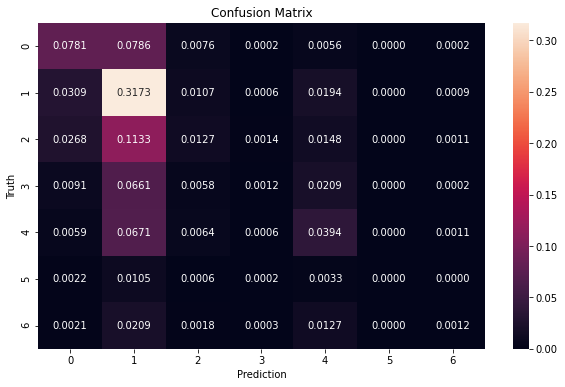

In [22]:
conf_matrix_rate=cm(y_test, y_pred)/sum(sum(cm(y_test, y_pred)))    # confusion matrix as a rate


fig, ax=plt.subplots(figsize=(10,6))

ax=sns.heatmap(conf_matrix_rate, 
               annot=True, 
               fmt='.4f',
               ax=ax)

plt.title('Confusion Matrix')
plt.ylabel('Truth')
plt.xlabel('Prediction')
plt.show();

## 7 - Oversampling

Now, we try to make a better model dealing with data itself. What happend if we do oversampling with SMOTE?

In [23]:
# your code here

X_train, X_test, y_train, y_test=tts(X, y, random_state=42)

In [24]:

oversample=SMOTE(sampling_strategy='not majority')

X_train, y_train=oversample.fit_resample(X_train, y_train)

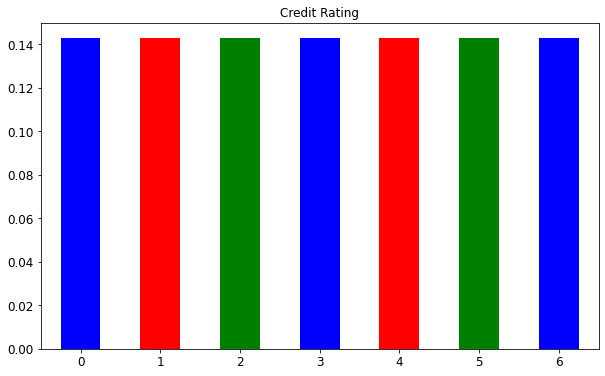

In [25]:
(y_train.value_counts()/len(y_train)).plot.bar(color=['b', 'r', 'g'],    # plot customer churn rate
                                               figsize=(10, 6),
                                               title='Credit Rating',
                                               rot=0,
                                               fontsize=12);

**Checking model with oversampled data**

In [26]:
logreg=LogisticRegression(max_iter=2000)

logreg.fit(X_train, y_train)

LogisticRegression(max_iter=2000)

In [27]:
y_pred=logreg.predict(X_test)

In [28]:
logreg.score(X_test, y_test)

0.376748673420164

In [29]:
f1(y_test, y_pred, average='macro')    # F1-score multilabel

0.26401790079548276

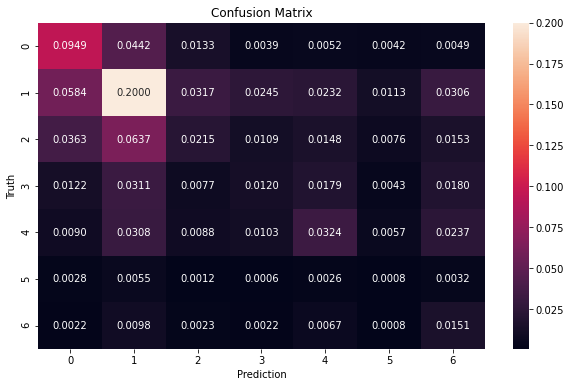

In [30]:
conf_matrix_rate=cm(y_test, y_pred)/sum(sum(cm(y_test, y_pred)))    # confusion matrix as a rate


fig, ax = plt.subplots(figsize=(10,6))

ax=sns.heatmap(conf_matrix_rate, 
               annot=True, 
               fmt='.4f',
               ax=ax)

plt.title('Confusion Matrix')
plt.ylabel('Truth')
plt.xlabel('Prediction')
plt.show();

## 8 - More models

We want to try another model, looking for a better accuracy. Which one you'll choose?

In [31]:
# your code here

X_train, X_test, y_train, y_test=tts(X, y, random_state=42)

In [32]:
rfc=RFC()
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [33]:
rfc.score(X_test, y_test)

0.47338800450233154

In [34]:
y_pred=rfc.predict(X_test)

In [35]:
f1(y_test, y_pred, average='macro')

0.24904133229194608

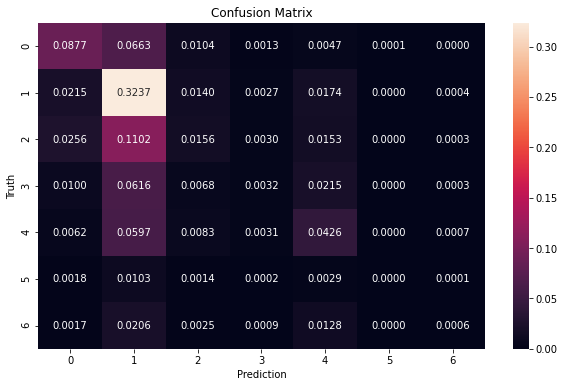

In [36]:
conf_matrix_rate=cm(y_test, y_pred)/sum(sum(cm(y_test, y_pred)))    

fig, ax = plt.subplots(figsize=(10,6))

ax=sns.heatmap(conf_matrix_rate, 
               annot=True, 
               fmt='.4f',
               ax=ax)

plt.title('Confusion Matrix')
plt.ylabel('Truth')
plt.xlabel('Prediction')
plt.show();

**with SMOTE**

In [37]:
oversample=SMOTE(sampling_strategy='not majority')

X_smote, y_smote=oversample.fit_resample(X, y)

In [38]:
X_train, X_test, y_train, y_test=tts(X_smote, y_smote, random_state=42)

In [39]:
rfc=RFC()
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [40]:
rfc.score(X_test, y_test)

0.7500534988230259

In [41]:
y_pred=rfc.predict(X_test)

In [42]:
f1(y_test, y_pred, average='macro')

0.7467804778538726

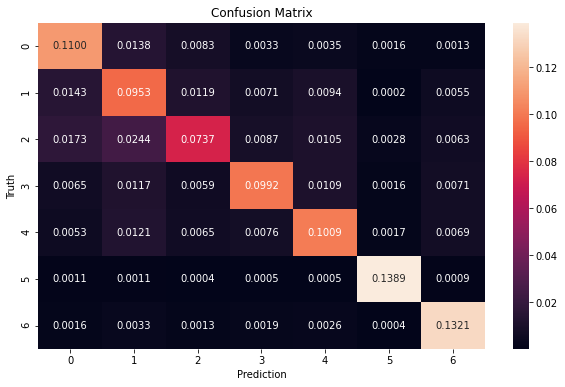

In [43]:
conf_matrix_rate=cm(y_test, y_pred)/sum(sum(cm(y_test, y_pred)))    

fig, ax = plt.subplots(figsize=(10,6))

ax=sns.heatmap(conf_matrix_rate, 
               annot=True, 
               fmt='.4f',
               ax=ax)

plt.title('Confusion Matrix')
plt.ylabel('Truth')
plt.xlabel('Prediction')
plt.show();

## 9 - Conclusions




In [44]:
# your answers here

Our data has imbalanced classes, because of that, our logistic regression model has a high bias. We try to fix it with SMOTE, but in this case is not working well. It is a bit better model, but no good enough.

However, when we choose another model, such random forest, SMOTE seems to work very well, improving F1-Score, almost 0.75

In this case, logistic regression is a bad model, in comparision with the random forest.